In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt

# Steps to fit a model: 

<img src="modeling_process.png" width=1000 height=800 style="horizontal-align:bottom">

# Arbitrary curve

${f(x) = x^{2} - 3 x - 7}$

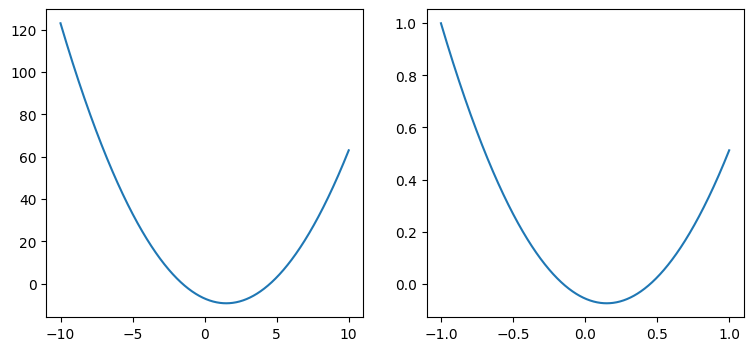

In [160]:
def curve1(x):
    return x**2 - 3 * x - 7

n_points = 1000

# Training data
x = torch.linspace(-10, 10, n_points)
y = curve1(x)

x_train = x / x.max()
y_train = y / y.max()

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.plot(x, y)

plt.subplot(1, 2, 2)
_ = plt.plot(x_train, y_train)

In [193]:
n_test_points = 250
# Testing data for interpolation
x_test_1 = torch.linspace(-9, 9, n_test_points).reshape(-1, 1)
y_test_1 = curve1(x_test_1).reshape(-1, 1)

x_test_1 = x_test_1 / x.max()
y_test_1 = y_test_1 / y.max()

# Testing data for extrapolation
x_test_2 = torch.linspace(-14.5, 14.5, n_test_points).reshape(-1, 1)
y_test_2 = curve1(x_test_2).reshape(-1, 1)

x_test_2 = x_test_2 / x.max()
y_test_2 = y_test_2 / y.max()

x_test_1.max(), x_test_2.max(), y_test_1.max(), y_test_2.max()

(tensor(0.9000), tensor(1.4500), tensor(0.8211), tensor(2.0061))

There are two ways to update the model's weights and biases during each epoch:

- Update once, by computing the gradients over the entire dataset (1 batch).
- (**prefered**) Update more than once, by computing the gradients over batches of the dataset (B batches).

Split the data into batches:

In [162]:
batch_size = 10
y_train = y_train.reshape(-1, batch_size, 1)
x_train = x_train.reshape(-1, batch_size, 1)
x_train.shape

torch.Size([100, 10, 1])

## Mathematical structure of a neuron

Despite there are many neural network arquitectures, most of them share the same mathematical expression the neuron:

1. It is a Linear Combination (LC) of the inputs from previous layers (inputs can be either a tensor of data or a tensor of the outputs from the last layer).
   
    $$\Large y_{l} = \sum_{u=1}^{N^{l}} (a^{u}_{l - 1})^{T} \cdot W^{u}_{l} + bias^{u}_{l}$$
   
   where
   
   - $l$ is the current layer .
   - $l - 1$ is the previous layer .
   - $y_{l}$ is the output of ``l``, in other words, it's a LC operation.
   - $N^{l}$ is the number of units (neurons) in ``l``.
   - $u$ is the index of the u-th neuron in ``l``.
   - $W^{u}_{l}$ is the **vector** of weights of the u-th neuron in ``l``. Its shape is [$N^{l-1}$, $N^{l}$])
   - $a^{u}_{l-1}$ is the **vector** of outputs from ``l - 1`` as inputs for ``l``. Its shape is [$N^{l-1}$, 1])
   - $(a^{u}_{l - 1})^{T}$ is the transpose $a^{u}_{l-1}$ of ``l - 1``
   - $bias^{u}_{l}$ is the bias term of the layer ``l``

1. Once the LC is computed, y_{l} is forwarded to an activation function $g(x)$. The objective of the activation function is to compute non-linear outputs for the next layers. This way the may capture complex features from the data.

    - Sigmoid:

      $$\Large g(x) = \frac{1}{1 + e^{-x}}$$
    - Relu (Rectified linear activation):

      $$\Large g(x) = max(x, 0)$$
    - Prelu (Parametric Relu):

      $$\Large g(x) = max(x, \alpha \cdot x)$$
    - TanH:

      $$\Large g(x) = \frac{2}{1 + e^{-2x}} - 1$$



## Activation Functions

- Sigmoid: it represents a cumulative distribution function (CDF).
    - Disadvantage: it saturates when $x\rightarrow \infty$ and $x\rightarrow -\infty$. This is a problem as the gradients become neglibible (~ 0.0) at those regions.
    - The sigmoid function is primarily used as an activation function in the output layer of supervised learning classification tasks, where it transforms the output into a probability score between 0 and 1.

- RELU: it can be interpreted as a 'switch' function, in other words, it activates the output when the input is positive, otherwise zero.

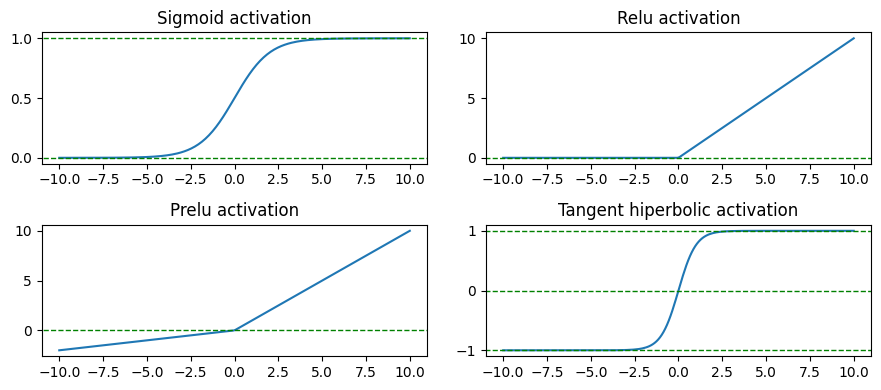

In [232]:
plt.figure(figsize=(9, 4))

n = 200

x = torch.linspace(-10, 10, n)

plt.subplot(2, 2, 1)

y_sigmoid = nn.functional.sigmoid(x)
plt.plot(x, y_sigmoid)
plt.axhline(y=0, xmin=-15, xmax=15, linestyle="--", linewidth=1, color="green")
plt.axhline(y=1, xmin=-15, xmax=15, linestyle="--", linewidth=1, color="green")
plt.title("Sigmoid activation")

plt.subplot(2, 2, 2)

y_relu = nn.functional.relu(x)
_ = plt.plot(x, y_relu)
plt.axhline(y=0, xmin=-15, xmax=15, linestyle="--", linewidth=1, color="green")
plt.title("Relu activation")

plt.subplot(2, 2, 3)

weight = torch.tensor(0.2)
y_prelu = nn.functional.prelu(x, weight)
plt.plot(x, y_prelu)
plt.axhline(y=0, xmin=-15, xmax=15, linestyle="--", linewidth=1, color="green")
plt.title("Prelu activation")

plt.subplot(2, 2, 4)

y_tanh = nn.functional.tanh(x)
_ = plt.plot(x, y_tanh)
plt.axhline(y=-1, xmin=-15, xmax=15, linestyle="--", linewidth=1, color="green")
plt.axhline(y=0, xmin=-15, xmax=15, linestyle="--", linewidth=1, color="green")
plt.axhline(y=1, xmin=-15, xmax=15, linestyle="--", linewidth=1, color="green")
plt.title("Tangent hiperbolic activation")

plt.tight_layout()

## Model defined in torch

### Training function

In [259]:
def train(model, x, y, criterion, optimizer, epochs=20):
    from copy import deepcopy
    
    avg_losses = []
    std_losses = []
    model_checkpoints = []
    n_show_log = 25
    n_save_checkpoint = 100

    # Set the model in training mode
    model.train()
    
    # Optimize/fit the model epochs times.
    for epoch in range(epochs):
        local_losses = []
        # Apply mini-batch 
        for inputs, target in zip(x, y):
            # Reset the gradients to zero in order to recompute them for a new batch
            optimizer.zero_grad()
            # Feed-forward step: compute the outputs
            outputs = model(inputs)
    
            # Compute the loss of between the current batch output and batch target
            loss = criterion(outputs, target)
            local_losses.append(loss)
    
            # Backpropagation step: compute and store the gradients via the loss
            loss.backward()
            # Apply gradient descent to update the parameters of the model (weights and biases)
            optimizer.step()
    
        ## ...At the end of the epoch... ##
        # Compute the mean of the loss
        mean_loss = sum(local_losses) / len(local_losses)
        avg_losses.append(mean_loss.item())
    
        # Compute the standard deviation (std) of the loss
        std_loss = torch.sum((torch.tensor(local_losses) - mean_loss)**2) / len(local_losses)
        std_losses.append(std_loss.item())
    
        # Show the log of losses
        if epoch > 0 and (epoch % n_show_log == 0):
            print(f"Mean loss at epoch {epoch}:\n\t{mean_loss}")
        
        # Ckeckpoint for models
        if epoch % n_save_checkpoint == 0:
            model_checkpoints.append(deepcopy(model.state_dict()))
            print(f"{len(model_checkpoints)}-th model checkpoint")

    # Set the model in evaluation mode
    model.eval()
    
    return model, avg_losses, std_loss, model_checkpoints

### One layer of 1 neuron (unit) + no activation

In [260]:
model = nn.Sequential()
model.append(nn.Linear(1, 1))

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

1-th model checkpoint
Mean loss at epoch 25:
	0.06273248791694641
Mean loss at epoch 50:
	0.062942273914814
Mean loss at epoch 75:
	0.06295499950647354
Mean loss at epoch 100:
	0.06295590102672577
2-th model checkpoint
Mean loss at epoch 125:
	0.06295596808195114
Mean loss at epoch 150:
	0.06295596808195114
Mean loss at epoch 175:
	0.06295597553253174
Mean loss at epoch 200:
	0.06295597553253174
3-th model checkpoint
Mean loss at epoch 225:
	0.06295597553253174
Mean loss at epoch 250:
	0.06295597553253174
Mean loss at epoch 275:
	0.06295597553253174
Mean loss at epoch 300:
	0.06295597553253174
4-th model checkpoint
Mean loss at epoch 325:
	0.06295597553253174
Mean loss at epoch 350:
	0.06295597553253174
Mean loss at epoch 375:
	0.06295597553253174
Mean loss at epoch 400:
	0.06295597553253174
5-th model checkpoint
Mean loss at epoch 425:
	0.06295597553253174
Mean loss at epoch 450:
	0.06295597553253174
Mean loss at epoch 475:
	0.06295597553253174
Mean loss at epoch 500:
	0.0629559755325

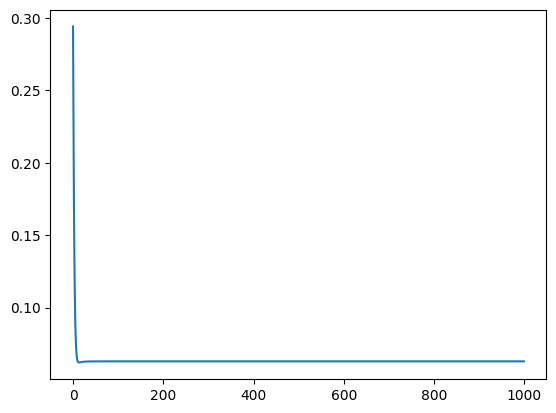

In [261]:
# Define the loss criterion to estimate the losses to be applied to update the parameters
criterion = nn.MSELoss()

# Define the algorithm for which computes the gradients
optimizer = torch.optim.Adam(model.parameters())

epochs = 1000
model, avg_losses, std_loss, model_checkpoints = train(model, x_train, y_train, criterion, optimizer, epochs=epochs)

# Plot the losses
plt.plot(avg_losses)

#### Plot test data for interpolation

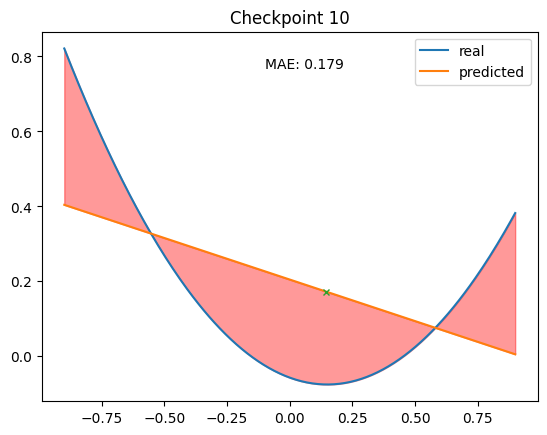

In [262]:
from time import sleep
from IPython.display import clear_output
import numpy as np

#x_test = torch.linspace(-8, 8, 200).reshape(-1, 1)
#y_test = curve1(x_test).reshape(-1, 1)

#x_test = x_test / x_train.max()
#y_test = y_test / y_train.max()

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    
    model.load_state_dict(state_dict)
    preds = model(x_test_1).detach()
    
    # Compute mae
    mae_eval_loss = torch.abs(preds - y_test_1).sum() / len(preds)
    test_point = 0.1 * torch.randn(1)
    test_pred = model(test_point).detach()
    
    fig, axes = plt.subplots(1, 1)
    # Plot real curve
    axes.plot(x_test_1, y_test_1, label="real")
    # Plot predicted curve
    axes.plot(x_test_1, preds, label="predicted")
    # Plot test point
    axes.plot(test_point, test_pred, markersize=5, marker="x")

    # Plot area between curves
    axes.fill_between(x_test_1.squeeze(), y_test_1.squeeze(), y2=preds.squeeze(), alpha=0.4, color="red")

    # Annotate the error on the plot
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    
    sleep(1)

#### Plot test data for extrapolation

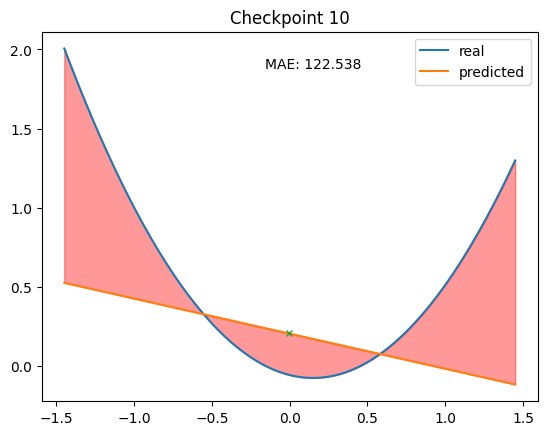

In [263]:
from time import sleep
from IPython.display import clear_output
import numpy as np

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    
    model.load_state_dict(state_dict)
    preds = model(x_test_2).detach().squeeze()
    
    # Compute mae
    mae_eval_loss = torch.abs(preds - y_test_2).sum() / len(preds)
    test_point = 0.1 * torch.randn(1)
    test_pred = model(test_point).detach()
    
    fig, axes = plt.subplots(1, 1)
    # Plot real curve
    axes.plot(x_test_2, y_test_2, label="real")
    # Plot predicted curve
    axes.plot(x_test_2, preds, label="predicted")
    # Plot test point
    axes.plot(test_point, test_pred, markersize=5, marker="x")

    # Plot area between curves
    axes.fill_between(x_test_2.squeeze(), y_test_2.squeeze(), y2=preds.squeeze(), alpha=0.4, color="red")

    # Annotate the error on the plot
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    
    sleep(1)

### One layer of 5 units + no activation

In [264]:
model = nn.Sequential()

model.append(nn.Linear(1, 5))
model.append(nn.Linear(5, 1)) # Output layer

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

1-th model checkpoint
Mean loss at epoch 25:
	0.06617709249258041
Mean loss at epoch 50:
	0.06510253250598907
Mean loss at epoch 75:
	0.06472186744213104
Mean loss at epoch 100:
	0.06487549096345901
2-th model checkpoint
Mean loss at epoch 125:
	0.06479772925376892
Mean loss at epoch 150:
	0.06497509777545929
Mean loss at epoch 175:
	0.06485115736722946
Mean loss at epoch 200:
	0.06491845101118088
3-th model checkpoint
Mean loss at epoch 225:
	0.06491708010435104
Mean loss at epoch 250:
	0.06493273377418518
Mean loss at epoch 275:
	0.06495340168476105
Mean loss at epoch 300:
	0.0649649128317833
4-th model checkpoint
Mean loss at epoch 325:
	0.06497932225465775
Mean loss at epoch 350:
	0.06499064713716507
Mean loss at epoch 375:
	0.06499984860420227
Mean loss at epoch 400:
	0.06500732153654099
5-th model checkpoint
Mean loss at epoch 425:
	0.06501208990812302
Mean loss at epoch 450:
	0.06501428782939911
Mean loss at epoch 475:
	0.06501349061727524
Mean loss at epoch 500:
	0.065009094774

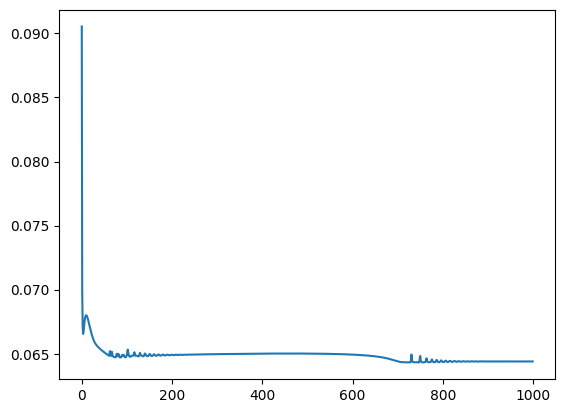

In [265]:
# Define the loss criterion to estimate the losses to be applied to update the parameters
criterion = nn.MSELoss()

# Define the algorithm for which computes the gradients. 
optimizer = torch.optim.Adam(model.parameters())

epochs = 1000
model, avg_losses, std_loss, model_checkpoints = train(model, x_train, y_train, criterion, optimizer, epochs=epochs)

# Plot the losses
plt.plot(avg_losses)

#### Plot test data for interpolation

In [266]:
from time import sleep
from IPython.display import clear_output
import numpy as np

#x_test = torch.linspace(-8, 8, 200).reshape(-1, 1)
#y_test = curve1(x_test).reshape(-1, 1)

#x_test = x_test / x_train.max()
#y_test = y_test / y_train.max()

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    
    model.load_state_dict(state_dict)
    preds = model(x_test_1).detach().squeeze()
    
    # Compute mae
    mae_eval_loss = torch.abs(preds - y_test_1).sum() / len(preds)
    test_point = 0.1 * torch.randn(1)
    test_pred = model(test_point).detach()
    
    fig, axes = plt.subplots(1, 1)
    # Plot real curve
    axes.plot(x_test_1, y_test_1, label="real")
    # Plot predicted curve
    axes.plot(x_test_1, preds, label="predicted", 1)
    # Plot test point
    axes.plot(test_point, test_pred, markersize=5, marker="x")

    # Plot area between curves
    axes.fill_between(x_test_1.squeeze(), y_test_1.squeeze(), y2=preds, alpha=0.4, color="red")

    # Annotate the error on the plot
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    
    sleep(1)

SyntaxError: positional argument follows keyword argument (2464274559.py, line 26)

#### Plot test data for extrapolation

In [ ]:
from time import sleep
from IPython.display import clear_output
import numpy as np

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    
    model.load_state_dict(state_dict)
    preds = model(x_test_2).detach().squeeze()
    
    # Compute mae
    mae_eval_loss = torch.abs(preds - y_test_2).sum() / len(preds)
    test_point = 0.1 * torch.randn(1)
    test_pred = model(test_point).detach()
    
    fig, axes = plt.subplots(1, 1)
    # Plot real curve
    axes.plot(x_test_2, y_test_2, label="real")
    # Plot predicted curve
    axes.plot(x_test_2, preds, label="predicted", 1)
    # Plot test point
    axes.plot(test_point, test_pred, markersize=5, marker="x")

    # Plot area between curves
    axes.fill_between(x_test_2.squeeze(), y_test_2.squeeze(), y2=preds, alpha=0.4, color="red")

    # Annotate the error on the plot
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    
    sleep(1)

### One layer of 1 units + Sigmoid activation

In [ ]:
model = nn.Sequential()

model.append(nn.Linear(1, 1))
model.append(nn.Sigmoid())
model.append(nn.Linear(1, 1)) # Output layer

In [ ]:
# Define the loss criterion to estimate the losses to be applied to update the parameters
criterion = nn.MSELoss()
# Define the algorithm for which computes the gradients. 
optimizer = torch.optim.Adam(model.parameters())

epochs = 1000
model, avg_losses, std_loss, model_checkpoints = train(model, x_train, y_train, criterion, optimizer, epochs=epochs)

# Plot the losses
plt.plot(avg_losses)

#### Plot test data for interpolation

In [ ]:
from time import sleep
from IPython.display import clear_output
import numpy as np

#x_test = torch.linspace(-8, 8, 200).reshape(-1, 1)
#y_test = curve1(x_test).reshape(-1, 1)

#x_test = x_test / x_train.max()
#y_test = y_test / y_train.max()

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    
    model.load_state_dict(state_dict)
    preds = model(x_test_1).detach()
    
    # Compute mae
    mae_eval_loss = torch.abs(preds - y_test_1).sum() / len(preds)
    test_point = 0.1 * torch.randn(1)
    test_pred = model(test_point).detach()
    
    fig, axes = plt.subplots(1, 1)
    # Plot real curve
    axes.plot(x_test_1, y_test_1, label="real")
    # Plot predicted curve
    axes.plot(x_test_1, preds, label="predicted")
    # Plot test point
    axes.plot(test_point, test_pred, markersize=5, marker="x")

    # Plot area between curves
    axes.fill_between(x_test_1.squeeze(), y_test_1.squeeze(), y2=preds.squeeze(), alpha=0.4, color="red")

    # Annotate the error on the plot
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    
    sleep(1)

#### Plot test data for extrapolation

In [ ]:
from time import sleep
from IPython.display import clear_output
import numpy as np

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    
    model.load_state_dict(state_dict)
    preds = model(x_test_2).detach().squeeze()
    
    # Compute mae
    mae_eval_loss = torch.abs(preds - y_test_2).sum() / len(preds)
    test_point = 0.1 * torch.randn(1)
    test_pred = model(test_point).detach()
    
    fig, axes = plt.subplots(1, 1)
    # Plot real curve
    axes.plot(x_test_2, y_test_2, label="real")
    # Plot predicted curve
    axes.plot(x_test_2, preds, label="predicted")
    # Plot test point
    axes.plot(test_point, test_pred, markersize=5, marker="x")

    # Plot area between curves
    axes.fill_between(x_test_2.squeeze(), y_test_2.squeeze(), y2=preds.squeeze(), alpha=0.4, color="red")

    # Annotate the error on the plot
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    
    sleep(1)

### One layer of 2 units + Relu activation

In [ ]:
model = nn.Sequential()

model.append(nn.Linear(1, 2))
model.append(nn.ReLU())
model.append(nn.Linear(2, 1)) # Output layer

In [ ]:
# Define the loss criterion to estimate the losses to be applied to update the parameters
criterion = nn.MSELoss()
# Define the algorithm for which computes the gradients. 
optimizer = torch.optim.Adam(model.parameters())

epochs = 1000
model, avg_losses, std_loss, model_checkpoints = train(model, x_train, y_train, criterion, optimizer, epochs=epochs)

# Plot the losses
plt.plot(avg_losses)

#### Plot test data for interpolation

In [ ]:
from time import sleep
from IPython.display import clear_output
import numpy as np

#x_test = torch.linspace(-8, 8, 200).reshape(-1, 1)
#y_test = curve1(x_test).reshape(-1, 1)

#x_test = x_test / x_train.max()
#y_test = y_test / y_train.max()

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    
    model.load_state_dict(state_dict)
    preds = model(x_test_1).detach()
    
    # Compute mae
    mae_eval_loss = torch.abs(preds - y_test_1).sum() / len(preds)
    test_point = 0.1 * torch.randn(1)
    test_pred = model(test_point).detach()
    
    fig, axes = plt.subplots(1, 1)
    # Plot real curve
    axes.plot(x_test_1, y_test_1, label="real")
    # Plot predicted curve
    axes.plot(x_test_1, preds, label="predicted")
    # Plot test point
    axes.plot(test_point, test_pred, markersize=5, marker="x")

    # Plot area between curves
    axes.fill_between(x_test_1.squeeze(), y_test_1.squeeze(), y2=preds.squeeze(), alpha=0.4, color="red")

    # Annotate the error on the plot
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    
    sleep(1)

#### Plot test data for extrapolation

In [ ]:
from time import sleep
from IPython.display import clear_output
import numpy as np

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    
    model.load_state_dict(state_dict)
    preds = model(x_test_2).detach().squeeze()
    
    # Compute mae
    mae_eval_loss = torch.abs(preds - y_test_2).sum() / len(preds)
    test_point = 0.1 * torch.randn(1)
    test_pred = model(test_point).detach()
    
    fig, axes = plt.subplots(1, 1)
    # Plot real curve
    axes.plot(x_test_2, y_test_2, label="real")
    # Plot predicted curve
    axes.plot(x_test_2, preds, label="predicted")
    # Plot test point
    axes.plot(test_point, test_pred, markersize=5, marker="x")

    # Plot area between curves
    axes.fill_between(x_test_2.squeeze(), y_test_2.squeeze(), y2=preds.squeeze(), alpha=0.4, color="red")

    # Annotate the error on the plot
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    
    sleep(1)

### One layer of 5 units + Relu activation

In [ ]:
model = nn.Sequential()

model.append(nn.Linear(1, 5))
model.append(nn.ReLU())
model.append(nn.Linear(5, 1)) # Output layer

In [ ]:
# Define the loss criterion to estimate the losses to be applied to update the parameters
criterion = nn.MSELoss()
# Define the algorithm for which computes the gradients. 
optimizer = torch.optim.Adam(model.parameters())

epochs = 1000
model, avg_losses, std_loss, model_checkpoints = train(model, x_train, y_train, criterion, optimizer, epochs=epochs)

# Plot the losses
plt.plot(avg_losses)

#### Plot test data for interpolation

In [ ]:
from time import sleep
from IPython.display import clear_output
import numpy as np

#x_test = torch.linspace(-8, 8, 200).reshape(-1, 1)
#y_test = curve1(x_test).reshape(-1, 1)

#x_test = x_test / x_train.max()
#y_test = y_test / y_train.max()

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    
    model.load_state_dict(state_dict)
    preds = model(x_test_1).detach()
    
    # Compute mae
    mae_eval_loss = torch.abs(preds - y_test_1).sum() / len(preds)
    test_point = 0.1 * torch.randn(1)
    test_pred = model(test_point).detach()
    
    fig, axes = plt.subplots(1, 1)
    # Plot real curve
    axes.plot(x_test_1, y_test_1, label="real")
    # Plot predicted curve
    axes.plot(x_test_1, preds, label="predicted")
    # Plot test point
    axes.plot(test_point, test_pred, markersize=5, marker="x")

    # Plot area between curves
    axes.fill_between(x_test_1.squeeze(), y_test_1.squeeze(), y2=preds.squeeze(), alpha=0.4, color="red")

    # Annotate the error on the plot
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    
    sleep(1)

#### Plot test data for extrapolation

In [ ]:
from time import sleep
from IPython.display import clear_output
import numpy as np

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    
    model.load_state_dict(state_dict)
    preds = model(x_test_2).detach().squeeze()
    
    # Compute mae
    mae_eval_loss = torch.abs(preds - y_test_2).sum() / len(preds)
    test_point = 0.1 * torch.randn(1)
    test_pred = model(test_point).detach()
    
    fig, axes = plt.subplots(1, 1)
    # Plot real curve
    axes.plot(x_test_2, y_test_2, label="real")
    # Plot predicted curve
    axes.plot(x_test_2, preds, label="predicted")
    # Plot test point
    axes.plot(test_point, test_pred, markersize=5, marker="x")

    # Plot area between curves
    axes.fill_between(x_test_2.squeeze(), y_test_2.squeeze(), y2=preds.squeeze(), alpha=0.4, color="red")

    # Annotate the error on the plot
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    
    sleep(1)

# Simple deflection of a beam

Create a model of one neuron to predict the deflection of a simply supported
beam subjected to its own weight (see expression [1]) and to a uniform distributed
loading q

$$\large q_{m} = den \cdot b \cdot h \cdot L$$

In [37]:
# Beam data

E_module = 30_000 # N / m2
width = 300 # 300 mm
height = 600 # 600 mm
length = 10000 # 10_000 mm
density = 25 # kN / m3

## Maximum deflection:

$$\large {y_{max}=\frac{5 \cdot q \cdot L^4}{384 \cdot E_{yg} \cdot I_{2}} }$$

In [38]:
def compute_load_weight(density, width, height, length):
    """
    Compute the load due to the own weight of a rectangular beam
    """
    return density * width * height * length * 10e-6

def compute_beam_inertia(width, height):
    """
    Compute the second moment of inertia of a rectangular beam
    """
    return (width * height**3) / 12
    
def max_arrow(q, length, young_module, inertia_2):
    """
    Compute the deflection due to the own weight of a rectangular beam
    """
    arrow_const = (5 * length**4) / (384 * young_module * inertia_2)
    return q * arrow_const

In [39]:
def generate_training_data(n_samples, width, height, length, density, young_module):
    inertia_2 = compute_beam_inertia(width, height)
    # Loads: own weight and distributed load
    q_weight = compute_load_weight(density, width, height, length)
    q_dist_load = 100 * torch.rand(size=(n_samples, ))
    
    # Deflections: own weight and distributed
    y_max_weight = max_arrow(q_weight, length, young_module, inertia_2) # y_max
    if not isinstance(y_max_weight, torch.Tensor):
        y_max_weight = torch.tensor(y_max_weight)
    y_max_dist = max_arrow(q_dist_load, length, young_module, inertia_2) # y_max
    
    return q_dist_load, y_max_dist + y_max_weight

In [40]:
n_samples = 1000

x, y = generate_training_data(n_samples, width, height, length, density, E_module)
x.shape, y.shape

(torch.Size([1000]), torch.Size([1000]))

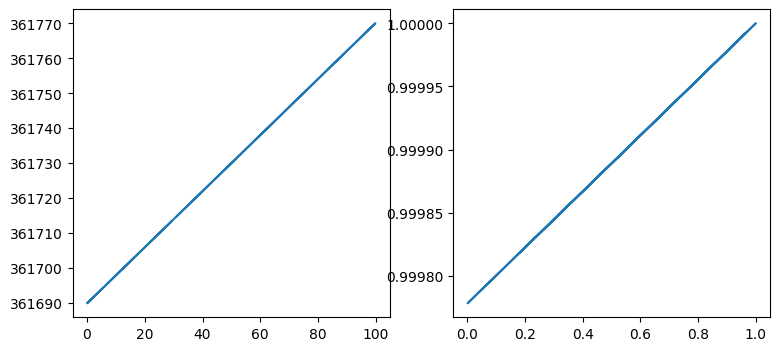

In [43]:
y_train = y / y.max()
x_train = x / x.max()

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.plot(x, y)

plt.subplot(1, 2, 2)
_ = plt.plot(x_train, y_train)

In [46]:
y_train = y_train.reshape(-1, 10, 1)
x_train = x_train.reshape(-1, 10, 1)
x_train.shape

torch.Size([50, 20, 1])

In [44]:
# Build the model: 1 Fully-connected layer (FCL) + Relu activation + 1 FCL (as output)
model = nn.Sequential()
model.append(nn.Linear(1, 16))
model.append(nn.ReLU())
model.append(nn.Linear(16, 1))

# Define the loss criterion to estimate the losses to be applied to update the parameters
criterion = nn.MSELoss()
# Define the algorithm for which computes the gradients. 
optimizer = torch.optim.Adam(model.parameters())

epochs = 1200
avg_losses = []
std_losses = []
model_checkpoints = []
n_show_log = 25
n_save_checkpoint = 100

from copy import deepcopy

# Optimize/fit the model epochs times.
for epoch in range(epochs):
    local_losses = []
    # Apply mini-batch 
    for inputs, target in zip(x_train, y_train):
        # Reset the gradients to zero in order to recompute them for a new batch
        optimizer.zero_grad()
        # Feed-forward step: compute the outputs
        outputs = model(inputs)

        # Compute the loss of between the current batch output and batch target
        loss = criterion(outputs, target)
        local_losses.append(loss)

        # Backpropagation step: compute and store the gradients via the loss
        loss.backward()
        # Apply gradient descent to update the parameters of the model (weights and biases)
        optimizer.step()

    ## ...At the end of the epoch... ##
    # Compute the mean of the loss
    mean_loss = sum(local_losses) / len(local_losses)
    avg_losses.append(mean_loss.item())

    # Compute the standard deviation (std) of the loss
    std_loss = torch.sum((torch.tensor(local_losses) - mean_loss)**2) / len(local_losses)
    std_losses.append(std_loss.item())

    # Show the log of losses
    if epoch > 0 and (epoch % n_show_log == 0):
        print(f"Mean loss at epoch {epoch}:\n\t{mean_loss}")
    
    # Ckeckpoint for models
    if epoch % n_save_checkpoint == 0:
        model_checkpoints.append(deepcopy(model.state_dict()))
        print(f"{len(model_checkpoints)}-th model checkpoint")

# Plot the losses
plt.plot(avg_losses)

RuntimeError: both arguments to linear need to be at least 1D, but they are 0D and 2D

In [ ]:
model.eval()
x = torch.linspace(-10, 10, 100)
y = curve1(x)

#real_curve, *_ = axes.plot([], [])
#pred_curve, *_ = axes.plot([], [])
#test_curve, *_ = axes.plot([], [])

#axes.set_xlim(-10, 10)
#axes.set_ylim(-10, 10)

from time import sleep
from IPython.display import clear_output
import numpy as np

for i, state_dict in enumerate(model_checkpoints):
    clear_output()
    model.load_state_dict(state_dict)
    preds = model(x.reshape(-1, 1)).detach().squeeze()
    # Compute mae
    mae_eval_loss = torch.abs(preds - y).sum() / len(preds)
    test_point = torch.randn(1)
    test_pred = model(test_point).detach()

    fig, axes = plt.subplots(1, 1)
    axes.plot(x, y, label="real")
    axes.plot(x, preds, label="predicted", 1)
    axes.plot(test_point, test_pred, markersize=5, marker="x")
    axes.fill_between(x, y, y2=preds, alpha=0.4, color="red")
    axes.annotate(f"MAE: {round(mae_eval_loss.item(), 3)}", xy=(0.45, 0.9), xycoords='axes fraction')
    
    axes.set_title(f"Checkpoint {i + 1}")
    plt.legend()
    plt.show()
    #real_curve.set_xdata(x)
    #real_curve.set_ydata(preds)
    #pred_curve.set_xdata(x)
    #pred_curve.set_ydata(preds)
    #test_curve.set_xdata(test_point)
    #test_curve.set_ydata(test_pred)
    
    sleep(3)